# Validating of our GP implementation
##### Author: Rodrigo Calderón (calderon@kasi.re.kr)
In this notebook, we validate our implementation by comparing with publicly available ones, namely [george](https://george.readthedocs.io/en/latest/).
For this you will need to install the ``george`` package by running the cell below

In [1]:
#!conda install -c conda-forge george

In [2]:
%cd ..

/Users/rodrigocalderon/Documents/github/IFPU-ModIC-workshop


In [3]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt 
plt.rc('font',size=16,family='sans-serif')
plt.rc('text',usetex=True)

Let's start by defining some useful functions 

In [4]:
%autoreload 2

def wf_George(data,x_pred,predict=True,optimize=True,plot_predictions=True,ax=None,bounds=None,plot_t_points=True):
    """
    Basic Workflow for computing GP predictions from a given dataset using George with an Exp2 kernel.
    Input the tuple (x,y,sigma_y) with data and array of x-values where you want to compute the predictions. 
    """
    import george
    from george import kernels

    x,y,sigma_y=data
    kernel=np.var(y)*kernels.ExpSquaredKernel((x[1]-x[0]))
    gp=george.GP(kernel)
    gp.compute(x,sigma_y)
    result={}
    
    if predict:
        result['pred_mean'], result['pred_var'] = gp.predict(y, x_pred, return_var=True)
        print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
        
    if optimize:
        from scipy.optimize import minimize

        def neg_ln_like(p):
            gp.set_parameter_vector(p)
            return -gp.log_likelihood(y)

        def grad_neg_ln_like(p):
            gp.set_parameter_vector(p)
            return -gp.grad_log_likelihood(y)
        
        result['opt']=minimize(neg_ln_like, gp.get_parameter_vector(),bounds=bounds,jac=grad_neg_ln_like)
        result['bf_val (log)']=result['opt'].x
        print("\nFinal ln-likelihood: {0:.3f} after optimization".format(gp.log_likelihood(y)))

        # update kernel values
        gp.set_parameter_vector(result['opt'].x)

        # compute predictions from optimized values for the hyperparameters
        result['pred_mean'], result['pred_var'] = gp.predict(y, x_pred, return_var=True)
        sf,ellf=np.exp(result['opt'].x)
        sf,ellf=np.sqrt(sf),np.sqrt(ellf)
        print(f'Best-fit values are: $\sigma_f$={sf:.3f} and $\ell_f={ellf:.3f}$\n')
        result['bf_point']=(sf,ellf)
        result['bounds']=bounds
        
    if plot_predictions:
        pred,pred_var=result['pred_mean'],result['pred_var']
        ax.plot(x_pred,pred,c='orange',lw=2.)
        [ax.fill_between(x_pred, pred - i*np.sqrt(pred_var), pred + i*np.sqrt(pred_var), color="gray", alpha=0.6/(i+1)) for i in [1,2]]
    
    if plot_t_points:
        ax.errorbar(x,y,sigma_y,fmt='.k',alpha=0.3)

    return gp, result

def wf_myGP(data,xpred,plot_prediction=True,fit_mean=False,ax=None,cov_mat=None,optimize=True,plt_kwargs={}):

    from src.gp import MyGP
    x,y,sigma_y=data
    gp=MyGP(fit_mean=fit_mean)
    gp.set_parameter_vector([np.sqrt(np.var(y)),x[0]-x[1]])
    gp.fit(x,sigma_y,cov_mat=cov_mat)
    gp.predict(y,xpred)
    if optimize:
        gp.optimize()
        
    if plot_prediction:
        gp.plot_prediction(xpred,ax=ax,**plt_kwargs)
    print(f'The LML for {gp.get_parameter_vector()} is {gp.LML(gp.get_parameter_vector()):.3f}')
    
    return gp

def plot_likelihood(gp,data,sigma_f,ell_f,cmap='viridis',sigma_diff=False,norm=0,fct='contour'):
    x,y,sigma_y=data
    X,Y=np.meshgrid(sigma_f,ell_f)
    Z=np.zeros_like(X)
    for i,sf in enumerate(sigma_f):
        for j,lf in enumerate(ell_f):
            # Notice the set_parameter_vector method in George takes the log of the hyperparameters squared
            gp.set_parameter_vector(np.log(np.array([sf,lf])**2))
            if sigma_diff:
                Z[j,i]=gp.log_likelihood(y)
                
    plt.contourf(X, Y, -Z, levels=np.linspace(-Z.flatten().max(),-Z.flatten().min(),50),cmap=cmap)
    plt.xscale('log');plt.yscale('log')
    plt.colorbar(label=r'$-\ln{\mathcal{L}}$')
    plt.xlabel(r'$\sigma_f$',fontsize='xx-large');plt.ylabel(r'$\ell_f$',fontsize='xx-large')

# A toy example

In [5]:
def generate_data(f,N=20,seed=1234):
    if seed is not None:
        np.random.seed(seed)
    
    x=np.linspace(0.1,10,N)*np.random.rand(N)
    cov=np.random.rand(N)*0.1*np.eye(N)
    y=np.random.multivariate_normal(f(x),cov)

    return x,y,np.diag(np.sqrt(cov))

truth=lambda x: np.sin(x)*np.log(x)
# truth=lambda x: np.ones_like(x)
# truth=lambda x: np.zeros_like(x)



Initial ln-likelihood: -8.04

Final ln-likelihood: -6.908 after optimization
Best-fit values are: $\sigma_f$=1.104 and $\ell_f=1.301$

The LML for [ 1.10390994 -1.30125863] is -6.908


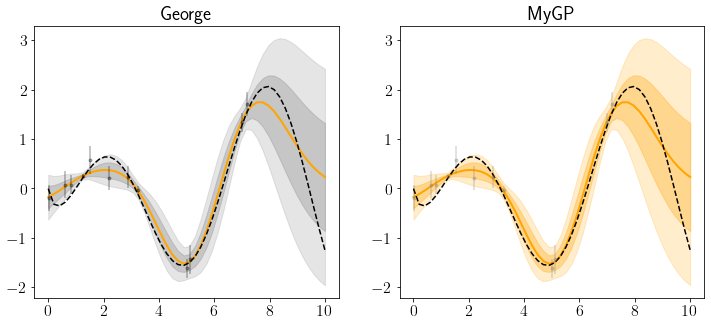

In [6]:
x,y,sigma_y=generate_data(truth,N=12)
xpred=np.linspace(1e-3,10)

fig,axs=plt.subplots(1,2,figsize=(12,5))
axs[0].set_title('George')
ggp,_=wf_George(data=(x,y,sigma_y),x_pred=xpred,ax=axs[0])
axs[0].plot(xpred,truth(xpred),ls='--',c='k')
plt.subplot(122)
axs[1].set_title('MyGP')
mygp=wf_myGP(data=(x,y,sigma_y),ax=axs[1],xpred=xpred)#,plt_kwargs={'colors':'C0'})
axs[1].plot(xpred,truth(xpred),ls='--',c='k')


We get identical results in both implementations!

## Inspecting the 2D likelihood profiles 

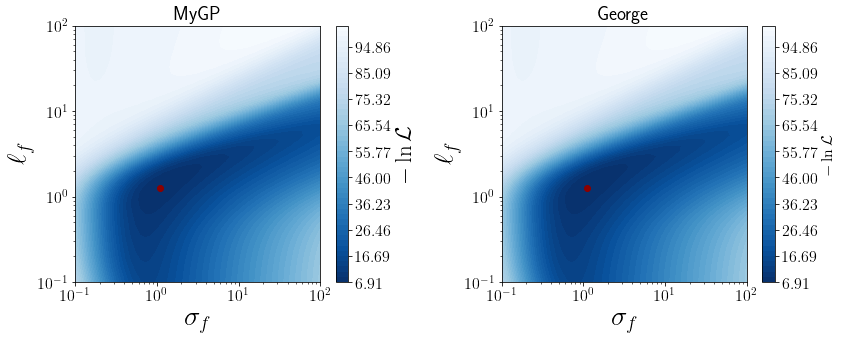

In [7]:
plt.figure(figsize=(12,5))
xy=np.logspace(-1,2,50)

plt.subplot(121)
plt.title('MyGP')
results=mygp.plot_likelihood(xy,xy,norm=-6.13,cmap='Blues_r',quiet=False)
bf=results['Best-fit Parameters']
plt.errorbar(x=bf[0],y=bf[1],fmt='o',c='darkred')

plt.subplot(122)
plt.title('George')
plot_likelihood(ggp,(x,y,sigma_y),xy,xy,cmap='Blues_r',norm=-6.13,sigma_diff=True)
plt.errorbar(x=bf[0],y=bf[1],fmt='o',c='darkred')
plt.tight_layout()

### Differences in the two implementations
Main differences to be aware of!

- ```George``` deals with the natural logarithm of the hyperparameters, i.e. the methods GP.set_parameter_vector($\theta$) & GP.set_parameter_vector($\theta$) are actually taking $\theta=(\ln{\sigma_f^2},\ln{\ell_f^2})$
- ```CosmoGP``` sets directly $\theta=(\sigma_f,\ell_f)$

## Exercise

* Generate mock $H(z)$ data from a $w_0w_a\rm CDM$  cosmology, and fit a GP on it with $\Lambda\rm CDM$ as mean function. 
* Inspect the LML 2D posterior distributions and check whether these suggest deviations from the mean.

## Example of Applications

**Calderón, Shafieloo, Hazra & Sohn 2023 - JCAP 08 (2023) 059**

[On the consistency of $\Lambda\rm CDM$ with CMB measurements in light of the latest Planck, ACT, and SPT data](https://arxiv.org/abs/2302.14300)

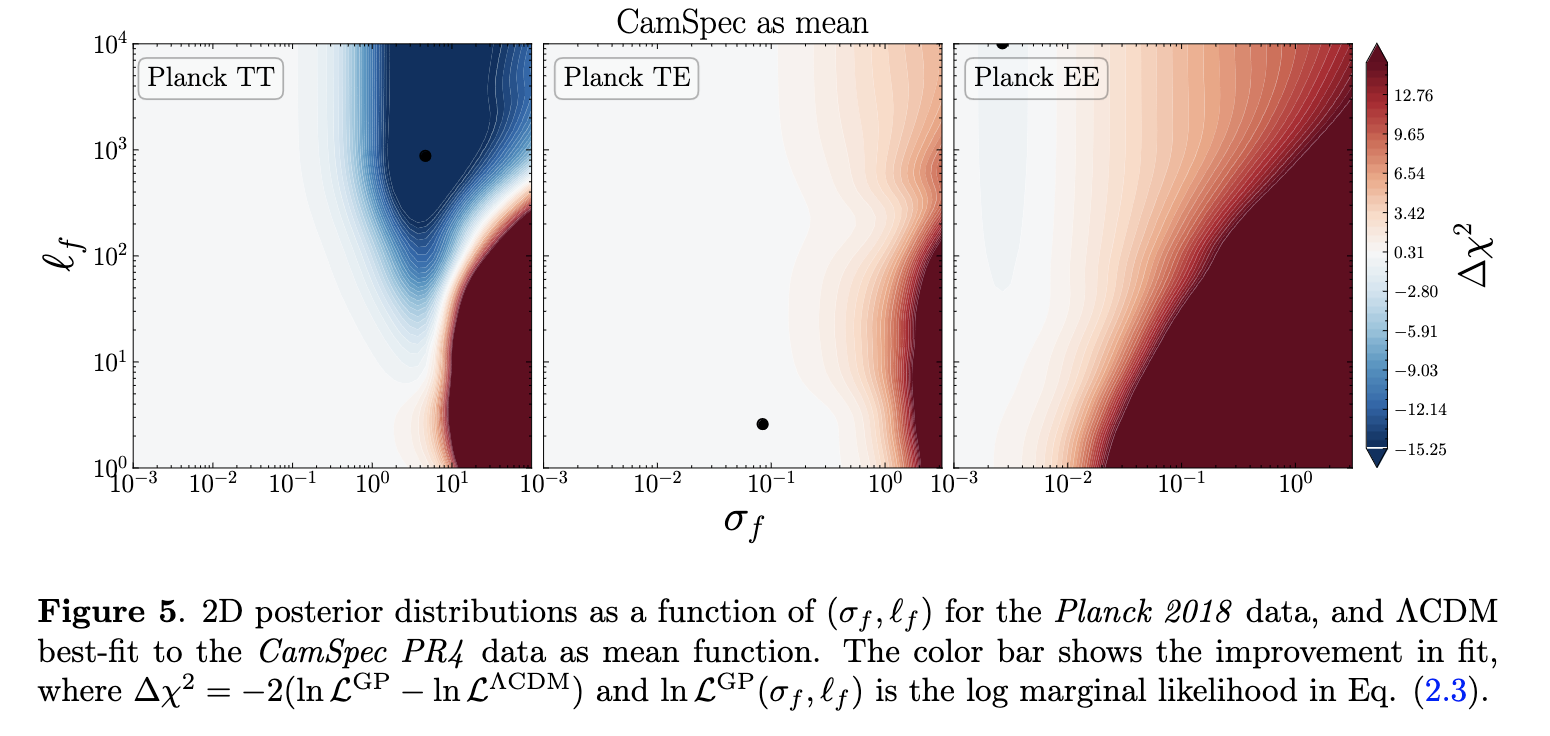

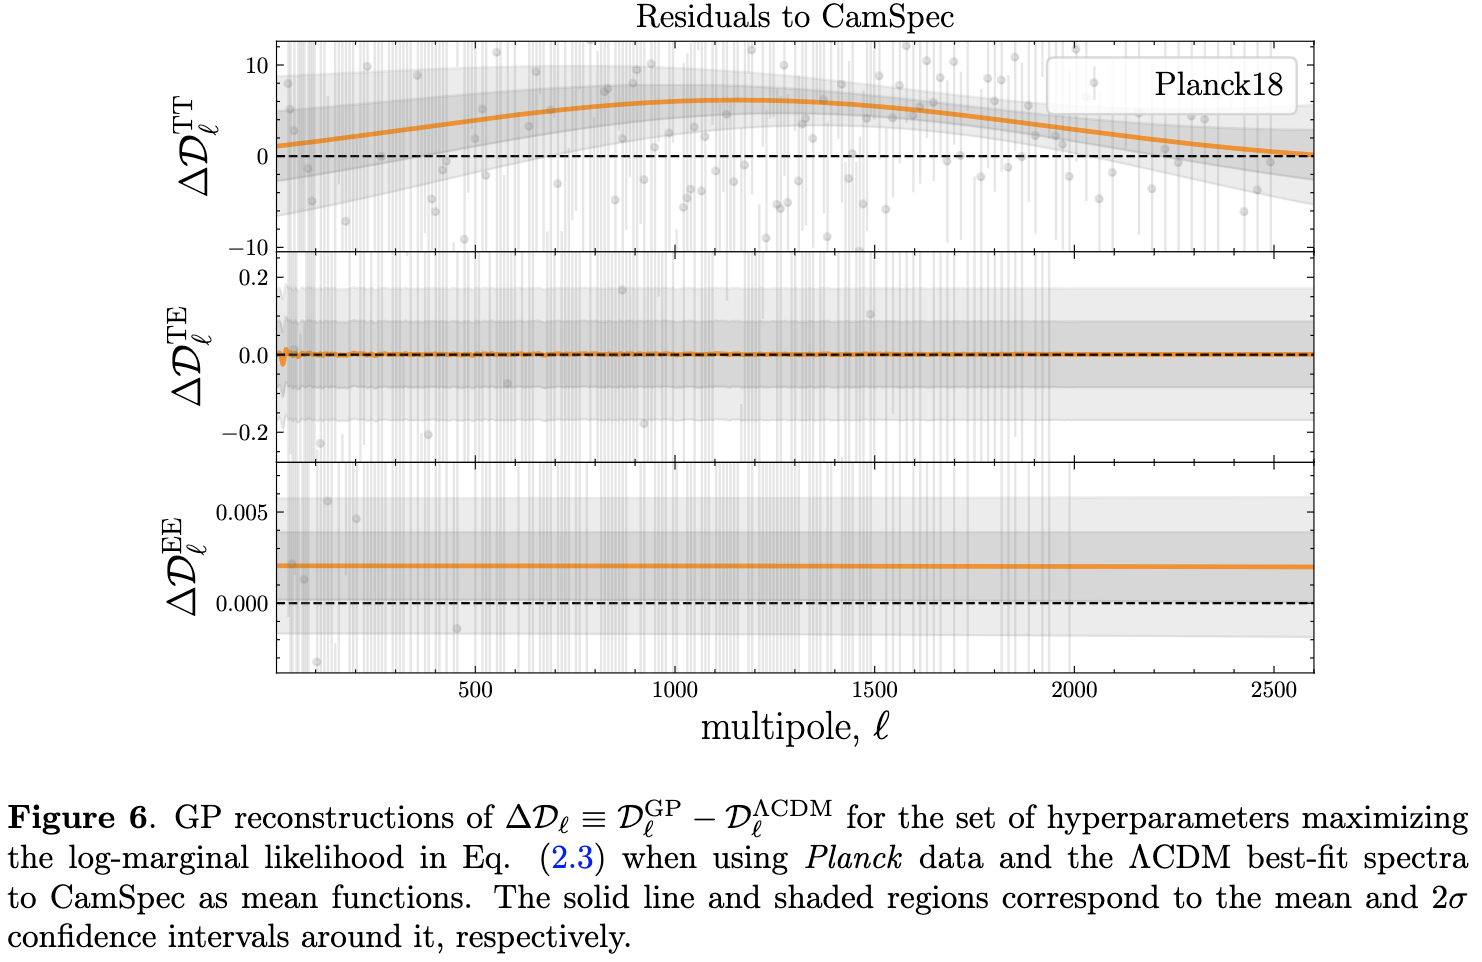